[2018-09-05 18:32:31 @gpus.py:39] Error reading GPU information, set no GPU.


(511, 640, 3) (511, 640, 3)
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


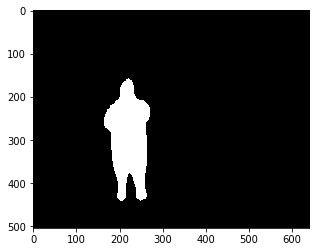

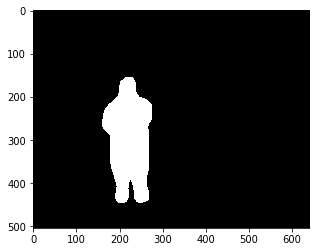

Shape of image: (504, 640, 3)
(1, 504, 640, 3)
Tensor("Const_16:0", shape=(1, 504, 1280, 3), dtype=float32)
Tensor("concat_8:0", shape=(1, 504, 640, 5), dtype=float32) 32
Model loaded.


In [ ]:
import argparse

import cv2, os
import numpy as np
import tensorflow as tf
import neuralgym as ng
import matplotlib.pyplot as plt
from inpaint_model import InpaintCAModel
# imgfolder='examples\\places2'
# imageloc = imgfolder + os.sep + 'building_input.png'
# maskloc = imgfolder + os.sep + 'building_mask.png'

imgfolder='..//..//resources'
imageloc = imgfolder + os.sep + '5951960966_d4e1cda5d0_z_2.jpg'
maskloc = imgfolder + os.sep + '5951960966_d4e1cda5d0_zmask.png'


checkpoint_dir = 'model_logs\\release_places2_256'

ng.get_gpus(1)

model = InpaintCAModel()
image = cv2.imread(imageloc)
mask = cv2.imread(maskloc)
print(image.shape, mask.shape)
assert image.shape == mask.shape
print(mask)
h, w, _ = image.shape
grid = 8
image = image[:h//grid*grid, :w//grid*grid, :]
mask = mask[:h//grid*grid, :w//grid*grid, :]
plt.imshow(mask)
plt.show()

kernel = np.ones((10,10),np.uint8)
mask = cv2.dilate(mask,kernel,iterations = 1)
plt.imshow(mask)
plt.show()

print('Shape of image: {}'.format(image.shape))
image = np.expand_dims(image, 0)
mask = np.expand_dims(mask, 0)
print(image.shape)
input_image = np.concatenate([image, mask], axis=2)

sess_config = tf.ConfigProto()
sess_config.gpu_options.allow_growth = True
with tf.Session(config=sess_config) as sess:
    input_image = tf.constant(input_image, dtype=tf.float32)
    print(input_image)
    output = model.build_server_graph(input_image, reuse=True)
    output = (output + 1.) * 127.5
    output = tf.reverse(output, [-1])
    output = tf.saturate_cast(output, tf.uint8)
    # load pretrained model
    vars_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
    assign_ops = []
    for var in vars_list:
        vname = var.name
        from_name = vname
        var_value = tf.contrib.framework.load_variable(checkpoint_dir, from_name)
        assign_ops.append(tf.assign(var, var_value))
    sess.run(assign_ops)
    print('Model loaded.')
    result = sess.run(output)
    cv2.imwrite('..\\..\\resources\\5951960966_d4e1cda5d0_z_out.png', result[0][:, :, ::-1])